In [34]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler

# —— Hyperparameters and Constants ——
BETA_START, BETA_END = 1e-4, 0.02
NOISE_STEPS = 1000
PATIENCE = 10
EPOCHS = 100
OUTPUT_DIR = 'diffusion_model_output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# —— Time Series Window Dataset ——
class TimeSeriesWindowDataset(Dataset):
    def __init__(self, data: np.ndarray, window_size: int):
        self.data = data
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        window = self.data[idx:idx + self.window_size]
        return window.astype(np.float32)

# —— Temporal Positional Encoding ——
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        # t: (batch,)
        device = t.device
        half = self.dim // 2
        freq = np.log(10000) / (half - 1)
        exponents = torch.exp(torch.arange(half, device=device) * -freq)
        args = t[:, None] * exponents[None, :]
        return torch.cat([torch.sin(args), torch.cos(args)], dim=1)

# —— MLP Denoising Network ——
class Denoiser(nn.Module):
    def __init__(self, window_size, feature_dim, latent_dim):
        super().__init__()
        hidden = 128
        input_dim = window_size * feature_dim + latent_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, window_size * feature_dim)
        )

    def forward(self, x_noisy, t_emb):
        # x_noisy: (batch, window_size*feature_dim)
        # t_emb:   (batch, latent_dim)
        return self.net(torch.cat([x_noisy, t_emb], dim=1))

# —— Main Diffusion Model Class ——
class TimeSeriesDiffusionModel:
    def __init__(self, window_size, feature_dim, latent_dim, lr, batch_size, device):
        self.window_size = window_size
        self.feature_dim = feature_dim
        self.latent_dim = latent_dim
        self.device = device

        # beta schedule
        self.betas = torch.linspace(BETA_START, BETA_END, NOISE_STEPS).to(device)
        self.alphas_cumprod = torch.cumprod(1 - self.betas, dim=0)

        # model & optimizer
        self.model = Denoiser(window_size, feature_dim, latent_dim).to(device)
        self.pos_emb = SinusoidalPosEmb(latent_dim).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def q_sample(self, x0, t, noise):
        # x0: (batch, D), t: (batch,), noise: (batch, D)
        a = self.alphas_cumprod[t]**0.5
        b = (1 - self.alphas_cumprod[t])**0.5
        return a[:, None] * x0 + b[:, None] * noise

    def p_loss(self, x0):
        batch = x0.size(0)
        t = torch.randint(0, NOISE_STEPS, (batch,), device=self.device)
        noise = torch.randn_like(x0)
        x_noisy = self.q_sample(x0, t, noise)
        pred = self.model(x_noisy, self.pos_emb(t))
        return nn.functional.mse_loss(pred, noise)

    def train(self, train_loader, val_loader):
        best_val, counter = float('inf'), 0
        for epoch in range(EPOCHS):
            # —— Training ——
            self.model.train()
            for batch in train_loader:
                x = batch.view(-1, self.window_size*self.feature_dim).to(self.device)
                self.optimizer.zero_grad()
                loss = self.p_loss(x)
                loss.backward()
                self.optimizer.step()

            # —— Validation ——
            self.model.eval()
            losses = []
            with torch.no_grad():
                for batch in val_loader:
                    x = batch.view(-1, self.window_size*self.feature_dim).to(self.device)
                    losses.append(self.p_loss(x).item())
            val_loss = sum(losses) / len(losses)

            print(f"Epoch {epoch+1}/{EPOCHS}  Val Loss: {val_loss:.6f}")
            if val_loss < best_val:
                best_val, counter = val_loss, 0
                torch.save(
                    self.model.state_dict(),
                    os.path.join(OUTPUT_DIR,
                                 f"best_diffusion_w{self.window_size}_ld{self.latent_dim}_lr{self.optimizer.param_groups[0]['lr']}.pth")
                )
            else:
                counter += 1
                if counter >= PATIENCE:
                    print("Early stopping.")
                    break

        return best_val


***Find the best output***

In [35]:
import os, re
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Subset

# ———— Configuration ————
INPUT_FEATHER = 'merged_data_cell_a_pdu6_pdu7_approx100machines_30d.feather'
TARGET_PDU    = 'pdu6'
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
FEAT          = ['pdu_sum_cpu_usage','production_power_util']
OUTPUT_DIR    = 'diffusion_model_output'


# ———— Load and preprocess data ————
df = pd.read_feather(INPUT_FEATHER)
df = df[df['pdu'] == TARGET_PDU].sort_values('datetime')
data = MinMaxScaler().fit_transform(df[FEAT].values)

# ———— Scan and evaluate each checkpoint ————
best_path, best_loss = None, float('inf')
pat = re.compile(r'best_diffusion_w(\d+)_ld(\d+)_lr([0-9\.e\-]+)\.pth')

for fn in os.listdir(OUTPUT_DIR):
    m = pat.match(fn)
    if not m:
        continue
    w, ld, lr = map(float, m.groups())
    w, ld = int(w), int(ld)

    # —— Reconstruct Dataset & DataLoader for current window_size=w ——
    ds = TimeSeriesWindowDataset(data, w)
    n = len(ds)
    val_ds = Subset(ds, range(int(0.8*n), n))
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

    # —— Initialize model ——
    model = TimeSeriesDiffusionModel(
        window_size=w,
        feature_dim=len(FEAT),
        latent_dim=ld,
        lr=lr,
        batch_size=32,
        device=DEVICE
    )
    # Switch to eval mode and load weights into the internal denoiser (Net)
    model.model.eval()
    ckpt = torch.load(os.path.join(OUTPUT_DIR, fn), map_location=DEVICE)
    model.model.load_state_dict(ckpt)

    # —— Compute average denoising loss on validation set ——
    losses = []
    with torch.no_grad():
        for win in val_loader:
            # win.shape = [batch, w, feature_dim]
            x0 = win.view(-1, w * len(FEAT)).to(DEVICE)
            losses.append(model.p_loss(x0).item())
    avg = np.mean(losses)
    print(f"{fn}: Val Loss = {avg:.6f}")

    if avg < best_loss:
        best_loss, best_path = avg, fn

print("Best model:", best_path, "Validation Loss:", best_loss)


best_diffusion_w64_ld16_lr0.0005.pth: Val Loss = 0.186111
best_diffusion_w64_ld16_lr0.001.pth: Val Loss = 0.190370
best_diffusion_w64_ld32_lr0.0005.pth: Val Loss = 0.196635
best_diffusion_w64_ld32_lr0.001.pth: Val Loss = 0.205112
best_diffusion_w96_ld16_lr0.0005.pth: Val Loss = 0.454012
best_diffusion_w96_ld16_lr0.001.pth: Val Loss = 0.439673
best_diffusion_w96_ld32_lr0.0005.pth: Val Loss = 0.438936
best_diffusion_w96_ld32_lr0.001.pth: Val Loss = 0.471402
Best model: best_diffusion_w64_ld16_lr0.0005.pth Validation Loss: 0.18611130366722742


***Distributional Similarity***

In [36]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import wasserstein_distance
import torch

# ------------------------------
# Configuration
# ------------------------------
INPUT_FEATHER = 'merged_data_cell_a_pdu6_pdu7_approx100machines_30d.feather'
CHECKPOINT = 'diffusion_model_output/best_diffusion_w64_ld16_lr0.001.pth'  
TARGET_PDU = 'pdu6'
FEATURE_COLS = ['pdu_sum_cpu_usage', 'production_power_util']

# Must match training setup
WINDOW_SIZE = 64
NOISE_STEPS = 1000
BETA_START, BETA_END = 1e-4, 0.02

# ------------------------------
# Model components (copied from diffusion_time_series.py)
# ------------------------------
class SinusoidalPosEmb(torch.nn.Module):
    def __init__(self, dim):
        super().__init__(); self.dim = dim
    def forward(self, t):
        device = t.device
        half = self.dim // 2
        emb = np.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=device) * -emb)
        emb = t[:, None].float() * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

class Denoiser(torch.nn.Module):
    def __init__(self, window_size, feature_dim, latent_dim):
        super().__init__()
        hid = 128
        in_dim = window_size * feature_dim + latent_dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_dim, hid), torch.nn.ReLU(),
            torch.nn.Linear(hid, hid), torch.nn.ReLU(),
            torch.nn.Linear(hid, window_size * feature_dim)
        )
    def forward(self, x_noisy, t_emb):
        h = torch.cat([x_noisy, t_emb], dim=1)
        return self.net(h)

class DiffusionModel(torch.nn.Module):
    def __init__(self, window_size, feature_dim, latent_dim, device):
        super().__init__()
        self.ws, self.fd, self.ld, self.dev = window_size, feature_dim, latent_dim, device
        # Beta / Alpha schedule
        self.betas = torch.linspace(BETA_START, BETA_END, NOISE_STEPS, device=device)
        self.alphas = 1 - self.betas
        self.acum = torch.cumprod(self.alphas, dim=0)
        # Model and positional encoding
        self.denoiser = Denoiser(window_size, feature_dim, latent_dim).to(device)
        self.posemb = SinusoidalPosEmb(latent_dim).to(device)

    def predict_noise(self, x, t):
        t_emb = self.posemb(t)
        return self.denoiser(x, t_emb)

    def sample(self, num_samples):
        # Start from pure noise
        x = torch.randn(num_samples, self.ws * self.fd, device=self.dev)
        for t in reversed(range(NOISE_STEPS)):
            t_tensor = torch.full((num_samples,), t, device=self.dev, dtype=torch.long)
            eps_theta = self.predict_noise(x, t_tensor)
            alpha_t    = self.alphas[t]
            alpha_cum  = self.acum[t]
            beta_t     = self.betas[t]

            # Posterior mean
            coef1 = 1.0 / torch.sqrt(alpha_t)
            coef2 = (1 - alpha_t) / torch.sqrt(1 - alpha_cum)
            mean = coef1 * (x - coef2 * eps_theta)

            if t > 0:
                prev_cum = self.acum[t-1]
                var = beta_t * (1 - prev_cum) / (1 - alpha_cum)
                x = mean + torch.sqrt(var) * torch.randn_like(x)
            else:
                x = mean

        # reshape, detach then to numpy
        return x.view(num_samples, self.ws, self.fd).detach().cpu().numpy()


# ------------------------------
# 1. Read and prepare real data windows
# ------------------------------
df = pd.read_feather(INPUT_FEATHER)
df = df[df['pdu'] == TARGET_PDU].sort_values('datetime')
data = df[FEATURE_COLS].values

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Construct sliding windows
real_windows = np.stack([
    data_scaled[i:i+WINDOW_SIZE]
    for i in range(len(data_scaled) - WINDOW_SIZE + 1)
])
print(f"Number of real windows: {real_windows.shape}")

# ------------------------------
# 2. Sample from the trained model
# ------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffusionModel(
    window_size=WINDOW_SIZE,
    feature_dim=len(FEATURE_COLS),
    latent_dim=16,   # Should match best model
    device=device
)
# Load checkpoint weights
ckpt = torch.load(CHECKPOINT, map_location=device)
model.denoiser.load_state_dict(ckpt)
model.to(device).eval()

gen_windows = model.sample(num_samples=real_windows.shape[0])
print(f"Number of generated windows: {gen_windows.shape}")

# ------------------------------
# 3. Compute MMD and Wasserstein
# ------------------------------
from scipy.spatial.distance import cdist

def compute_mmd(x, y, sigma=None):
    x = x.reshape(x.shape[0], -1)
    y = y.reshape(y.shape[0], -1)
    XY = np.vstack([x, y])
    dists = cdist(XY, XY, 'sqeuclidean')
    if sigma is None:
        med = np.median(dists[np.triu_indices_from(dists, k=1)])
        sigma = np.sqrt(0.5 * med)
    def rbf(a, b):
        return np.exp(-cdist(a, b, 'sqeuclidean') / (2 * sigma**2))
    Kxx = rbf(x, x); Kyy = rbf(y, y); Kxy = rbf(x, y)
    m, n = x.shape[0], y.shape[0]
    mmd2 = Kxx.sum()/(m*m) + Kyy.sum()/(n*n) - 2*Kxy.sum()/(m*n)
    return np.sqrt(max(mmd2,0))

# MMD
mmd = compute_mmd(real_windows, gen_windows)
print(f"MMD: {mmd:.6f}")

# Wasserstein: compute per-dimension and take the mean
real_flat = real_windows.reshape(real_windows.shape[0], -1)
gen_flat  = gen_windows.reshape(gen_windows.shape[0], -1)
ws = np.mean([
    wasserstein_distance(real_flat[:,i], gen_flat[:,i])
    for i in range(real_flat.shape[1])
])
print(f"Mean Wasserstein Distance: {ws:.6f}")


Number of real windows: (2818, 64, 2)
Number of generated windows: (2818, 64, 2)
MMD: 0.687789
Mean Wasserstein Distance: 41.988027


***Kolmogorov–Smirnov Test***

In [37]:
from scipy.stats import ks_2samp

# 1. Perform KS test per feature dimension
num_features = real_windows.shape[2]
for f in range(num_features):
    real_vals = real_windows[:, :, f].ravel()
    gen_vals  = gen_windows[:, :, f].ravel()
    stat, p = ks_2samp(real_vals, gen_vals)
    print(f"Feature {f} KS statistic = {stat:.4f}, p-value = {p:.4e}")

# 2. Global KS test (flatten across all time points and features)
stat_all, p_all = ks_2samp(real_windows.ravel(), gen_windows.ravel())
print(f"\nGlobal KS statistic = {stat_all:.4f}, p-value = {p_all:.4e}")


Feature 0 KS statistic = 0.5075, p-value = 0.0000e+00
Feature 1 KS statistic = 0.5119, p-value = 0.0000e+00

Global KS statistic = 0.4982, p-value = 0.0000e+00


***Visual Comparison***

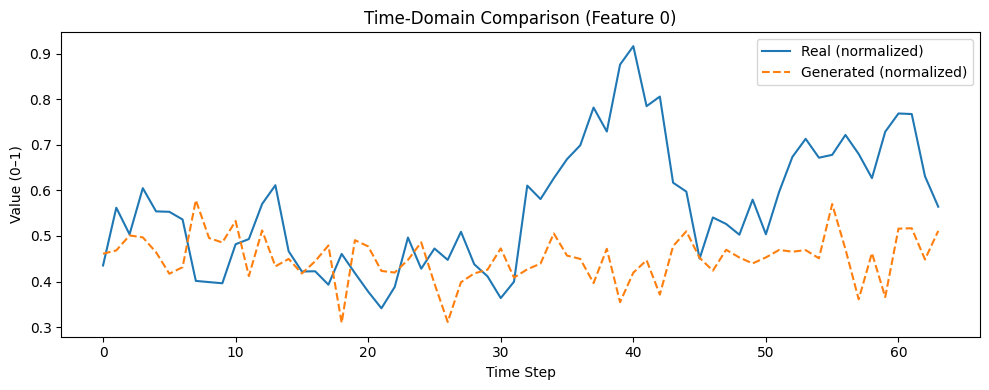

C:\Users\21134\AppData\Roaming\Python\Python312\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 64, using nperseg = 64
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


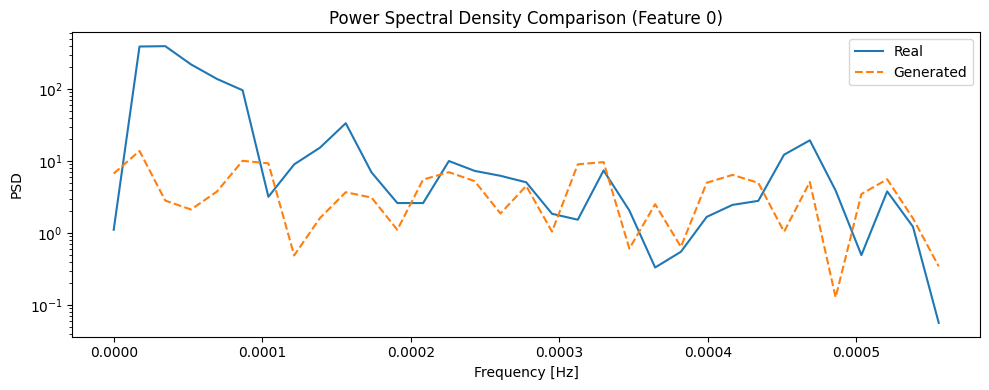

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Compare the first feature
real_feat = real_windows[..., 0]  # Shape: (N, WINDOW_SIZE)
gen_feat  = gen_windows[..., 0]

# Normalize generated sequences to [0,1]
gmin, gmax = gen_feat.min(), gen_feat.max()
gen_scaled = (gen_feat - gmin) / (gmax - gmin + 1e-8)

# Randomly select one window
np.random.seed(42)
idx = np.random.randint(real_feat.shape[0])
real_seq = real_feat[idx]
gen_seq  = gen_scaled[idx]

# —— Time-domain comparison ——
plt.figure(figsize=(10, 4))
plt.plot(real_seq, label='Real (normalized)')
plt.plot(gen_seq,  label='Generated (normalized)', linestyle='--')
plt.title('Time-Domain Comparison (Feature 0)')
plt.xlabel('Time Step')
plt.ylabel('Value (0–1)')
plt.legend()
plt.tight_layout()
plt.show()

# —— Frequency-domain comparison (PSD) ——
# Sampling interval is 15 minutes => fs = 1/(15*60) Hz
fs = 1.0 / (15 * 60)
f_r, Pxx_r = welch(real_seq, fs=fs)
f_g, Pxx_g = welch(gen_seq,  fs=fs)

plt.figure(figsize=(10, 4))
plt.semilogy(f_r, Pxx_r, label='Real')
plt.semilogy(f_g, Pxx_g, label='Generated', linestyle='--')
plt.title('Power Spectral Density Comparison (Feature 0)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.legend()
plt.tight_layout()
plt.show()


***Downstream Evaluation***

Real windows: (2818, 64, 2)
Generated windows: (2818, 64, 2)
Real data -> Avg Grid Draw: 0.4848, Avg Violations: 0.81
Gen data  -> Avg Grid Draw: 1.0711, Avg Violations: 32.50


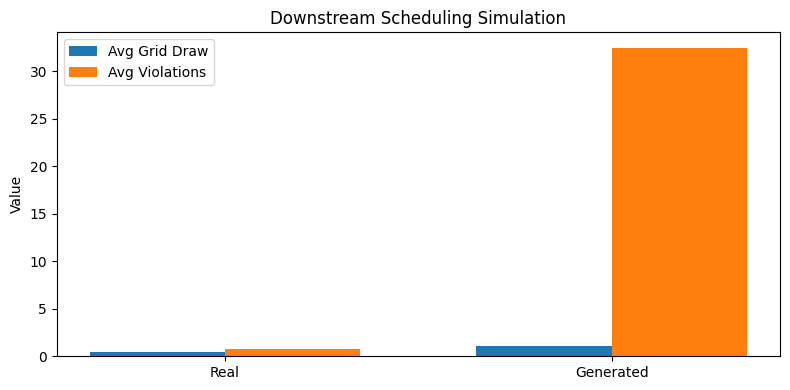

In [39]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.signal import welch

# ------------------------------
# Configuration
# ------------------------------
FEATHER_FILE   = 'merged_data_cell_a_pdu6_pdu7_approx100machines_30d.feather'
CHECKPOINT     = 'diffusion_model_output/best_diffusion_w64_ld16_lr0.001.pth'
TARGET_PDU     = 'pdu6'
FEATURE_COLS   = ['pdu_sum_cpu_usage', 'production_power_util']
WINDOW_SIZE    = 64
GRID_LIMIT     = 0.8   # normalized grid capacity
B_MAX          = 0.5   # normalized battery capacity
SEED           = 42

# ------------------------------
# Diffusion model components
# ------------------------------
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        device = t.device
        half = self.dim // 2
        emb = np.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=device) * -emb)
        emb = t[:, None].float() * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

class Denoiser(nn.Module):
    def __init__(self, window_size, feature_dim, latent_dim):
        super().__init__()
        hidden = 128
        input_dim = window_size * feature_dim + latent_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden),   nn.ReLU(),
            nn.Linear(hidden, window_size * feature_dim)
        )
    def forward(self, x, t_emb):
        h = torch.cat([x, t_emb], dim=1)
        return self.net(h)

class DiffusionModel(nn.Module):
    def __init__(self, window_size, feature_dim, latent_dim, device):
        super().__init__()
        self.ws, self.fd, self.ld, self.dev = window_size, feature_dim, latent_dim, device
        self.noise_steps = 1000
        self.betas = torch.linspace(1e-4, 0.02, self.noise_steps, device=device)
        self.alphas = 1 - self.betas
        self.acum   = torch.cumprod(self.alphas, dim=0)
        self.denoiser = Denoiser(window_size, feature_dim, latent_dim).to(device)
        self.posemb   = SinusoidalPosEmb(latent_dim).to(device)

    def predict_noise(self, x, t):
        t_emb = self.posemb(t)
        return self.denoiser(x, t_emb)

    def sample(self, n):
        x = torch.randn(n, self.ws * self.fd, device=self.dev)
        for t in reversed(range(self.noise_steps)):
            t_tensor = torch.full((n,), t, device=self.dev, dtype=torch.long)
            eps_theta = self.predict_noise(x, t_tensor)
            alpha_t    = self.alphas[t]
            alpha_cum  = self.acum[t]
            beta_t     = self.betas[t]
            coef1 = 1.0 / torch.sqrt(alpha_t)
            coef2 = (1 - alpha_t) / torch.sqrt(1 - alpha_cum)
            mean  = coef1 * (x - coef2 * eps_theta)
            if t > 0:
                prev_cum = self.acum[t-1]
                var = beta_t * (1 - prev_cum) / (1 - alpha_cum)
                x = mean + torch.sqrt(var) * torch.randn_like(x)
            else:
                x = mean
        return x.view(n, self.ws, self.fd).detach().cpu().numpy()


# ------------------------------
# 1. Load and prepare real data
# ------------------------------
np.random.seed(SEED)

# Read feather
try:
    df = pd.read_feather(FEATHER_FILE)
except ImportError:
    raise ImportError("no pyarrow!!!!!!!!!!")

# Filter and sort
df = df[df['pdu'] == TARGET_PDU].sort_values('datetime')
data = df[FEATURE_COLS].values.astype(float)
# Manual normalization
data_min = data.min(axis=0)
data_max = data.max(axis=0)
data_scaled = (data - data_min) / (data_max - data_min + 1e-8)
# Sliding windows
real_windows = np.stack([data_scaled[i:i+WINDOW_SIZE]
                         for i in range(len(data_scaled) - WINDOW_SIZE + 1)])
print(f"Real windows: {real_windows.shape}")

# ------------------------------
# 2. Load model and generate synthetic windows
# ------------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffusionModel(WINDOW_SIZE, len(FEATURE_COLS), latent_dim=16, device=device)
ckpt = torch.load(CHECKPOINT, map_location=device)
model.denoiser.load_state_dict(ckpt)
model.eval()
# Sample
gen_windows = model.sample(real_windows.shape[0])
print(f"Generated windows: {gen_windows.shape}")

# ------------------------------
# 3. Downstream battery dispatch simulation
# ------------------------------
def simulate_battery_dispatch(traces, grid_limit, B_max, eff=0.95):
    results = []
    for seq in traces[:, :, 0]:  # first feature
        B = B_max / 2
        total_draw = 0.0
        violations = 0
        for u in seq:
            if u > grid_limit:
                need = u - grid_limit
                take = min(B, need / eff)
                discharge = take * eff
                B -= take
                grid_draw = u - discharge
                if grid_draw > grid_limit:
                    violations += 1
            else:
                charge = min(grid_limit - u, (B_max - B) / eff)
                B += charge * eff
                grid_draw = u
            total_draw += grid_draw
        avg_grid = total_draw / len(seq)
        results.append((avg_grid, violations))
    return results

# Run simulation
grid_limit, B_max = GRID_LIMIT, B_MAX
real_metrics = simulate_battery_dispatch(real_windows, grid_limit, B_max)
gen_metrics  = simulate_battery_dispatch(gen_windows,   grid_limit, B_max)

# Summarize
def summarize(metrics):
    avg_draw = np.mean([m[0] for m in metrics])
    avg_viol = np.mean([m[1] for m in metrics])
    return avg_draw, avg_viol

real_summary = summarize(real_metrics)
gen_summary  = summarize(gen_metrics)
print(f"Real data -> Avg Grid Draw: {real_summary[0]:.4f}, Avg Violations: {real_summary[1]:.2f}")
print(f"Gen data  -> Avg Grid Draw: {gen_summary[0]:.4f}, Avg Violations: {gen_summary[1]:.2f}")

# ------------------------------
# 4. Visualization
# ------------------------------
labels = ['Real', 'Generated']
avg_draws = [real_summary[0], gen_summary[0]]
viol_counts = [real_summary[1], gen_summary[1]]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, avg_draws, width, label='Avg Grid Draw')
plt.bar(x + width/2, viol_counts, width, label='Avg Violations')
plt.xticks(x, labels)
plt.ylabel('Value')
plt.title('Downstream Scheduling Simulation')
plt.legend()
plt.tight_layout()
plt.show()
